In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:

np.random.seed(42)
n_samples = 1000

In [5]:
data = {
    'pm25': np.random.gamma(2, 15, n_samples),  # PM2.5 (µg/m³)
    'pm10': np.random.gamma(3, 20, n_samples),  # PM10 (µg/m³)
    'co': np.random.gamma(1.5, 0.8, n_samples),  # Carbon Monoxide (ppm)
    'no2': np.random.gamma(2, 15, n_samples),  # Nitrogen Dioxide (ppb)
    'o3': np.random.gamma(2, 20, n_samples),  # Ozone (ppb)
    'temperature': np.random.normal(23, 5, n_samples),  # Temperature (°C)
    'humidity': np.random.normal(60, 15, n_samples),  # Humidity (%)
    'work_hours': np.random.uniform(6, 10, n_samples),  # Work hours
}

df = pd.DataFrame(data)

In [6]:
df['pm25'] = df['pm25'].clip(0, 150)
df['pm10'] = df['pm10'].clip(0, 200)
df['co'] = df['co'].clip(0, 5)
df['no2'] = df['no2'].clip(0, 100)
df['o3'] = df['o3'].clip(0, 150)
df['temperature'] = df['temperature'].clip(10, 35)
df['humidity'] = df['humidity'].clip(20, 90)

productivity_base = 85

pm25_impact = -0.3 * df['pm25']
pm10_impact = -0.15 * df['pm10']
co_impact = -8 * df['co']
no2_impact = -0.2 * df['no2']
o3_impact = -0.1 * df['o3']

In [7]:
temp_optimal = 22
temp_impact = -0.5 * np.abs(df['temperature'] - temp_optimal)

humidity_impact = -0.1 * np.abs(df['humidity'] - 50)

work_impact = 2 * df['work_hours'] - 0.15 * (df['work_hours'] ** 2)

df['productivity_score'] = (
    productivity_base + 
    pm25_impact + pm10_impact + co_impact + no2_impact + o3_impact +
    temp_impact + humidity_impact + work_impact +
    np.random.normal(0, 5, n_samples)
)

In [8]:
df['productivity_score'] = df['productivity_score'].clip(0, 100)

df['day_of_week'] = np.random.choice(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], n_samples)
df['season'] = np.random.choice(['Spring', 'Summer', 'Fall', 'Winter'], n_samples)

df.to_csv('air_quality_productivity.csv', index=False)
print(f"Dataset created with {len(df)} samples")

Dataset created with 1000 samples


In [9]:
print("Dataset Info:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nCorrelation with Productivity Score:")
correlations = df.select_dtypes(include=[np.number]).corr()['productivity_score'].sort_values(ascending=False)
print(correlations)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pm25                1000 non-null   float64
 1   pm10                1000 non-null   float64
 2   co                  1000 non-null   float64
 3   no2                 1000 non-null   float64
 4   o3                  1000 non-null   float64
 5   temperature         1000 non-null   float64
 6   humidity            1000 non-null   float64
 7   work_hours          1000 non-null   float64
 8   productivity_score  1000 non-null   float64
 9   day_of_week         1000 non-null   object 
 10  season              1000 non-null   object 
dtypes: float64(9), object(2)
memory usage: 86.1+ KB
None

Statistical Summary:
              pm25         pm10           co          no2           o3  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     30.898

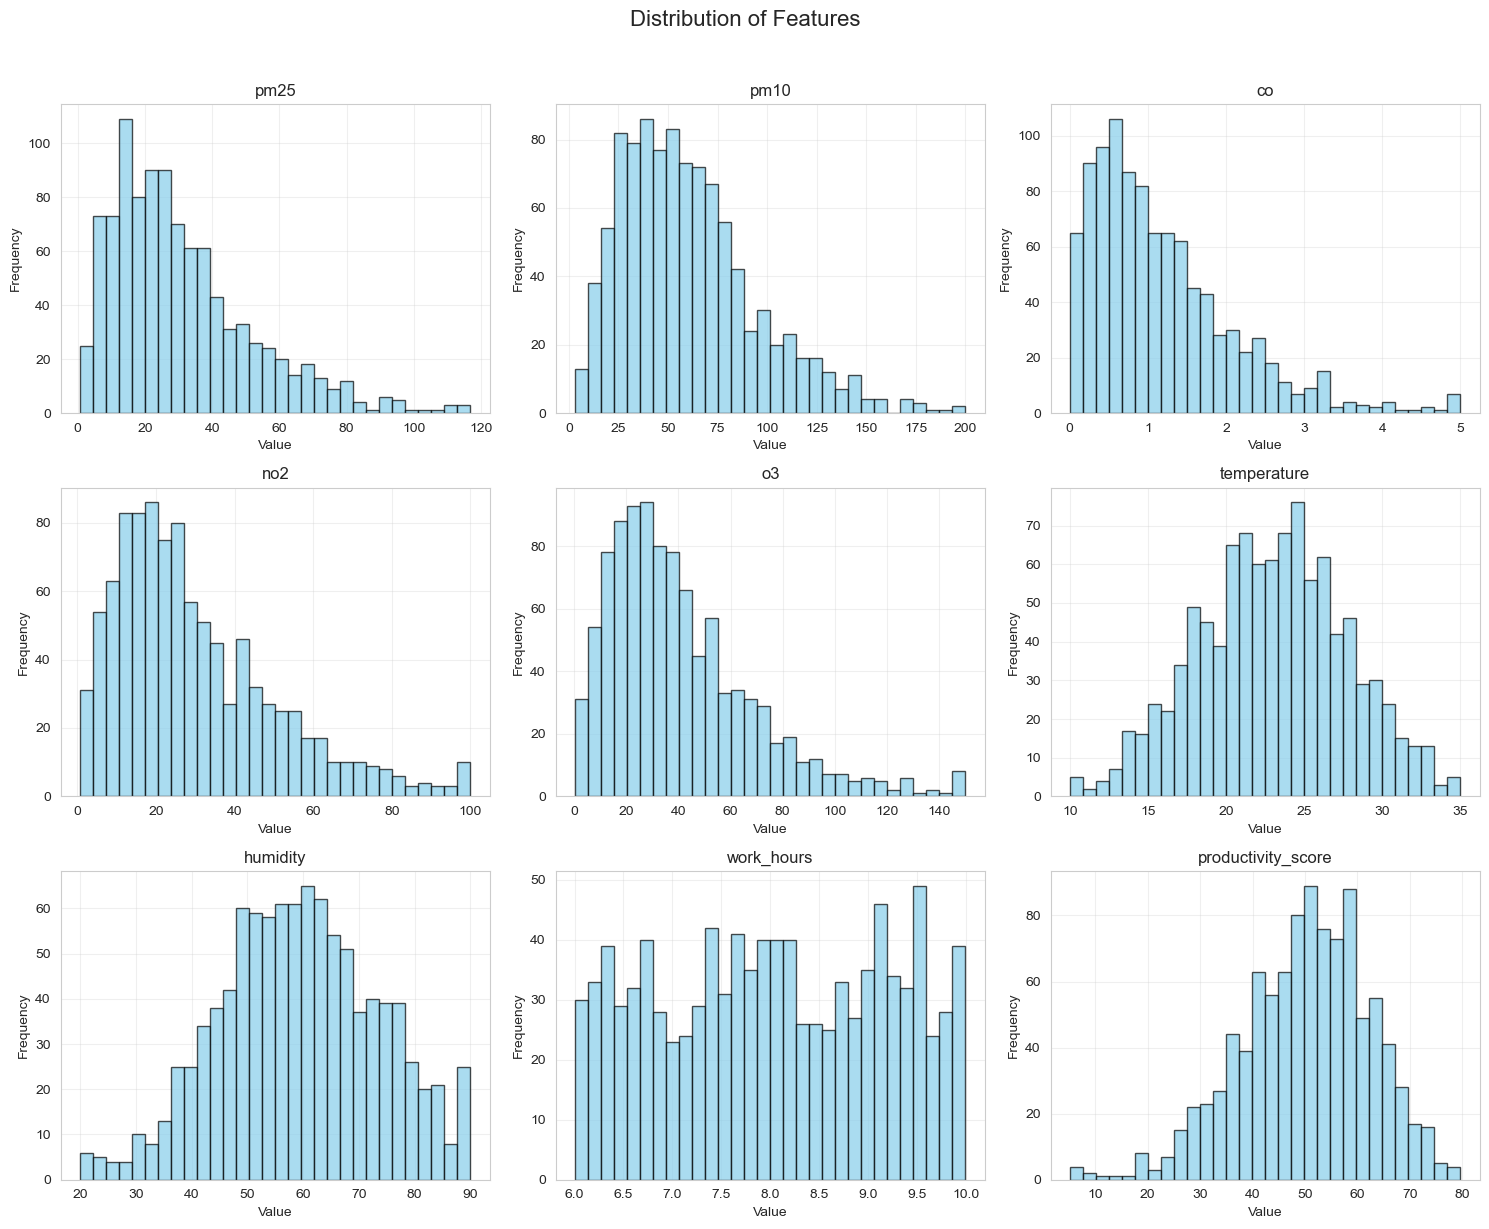

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Distribution of Features', fontsize=16, y=1.02)

features = ['pm25', 'pm10', 'co', 'no2', 'o3', 'temperature', 'humidity', 'work_hours', 'productivity_score']
for idx, feature in enumerate(features):
    ax = axes[idx // 3, idx % 3]
    ax.hist(df[feature], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_title(f'{feature}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

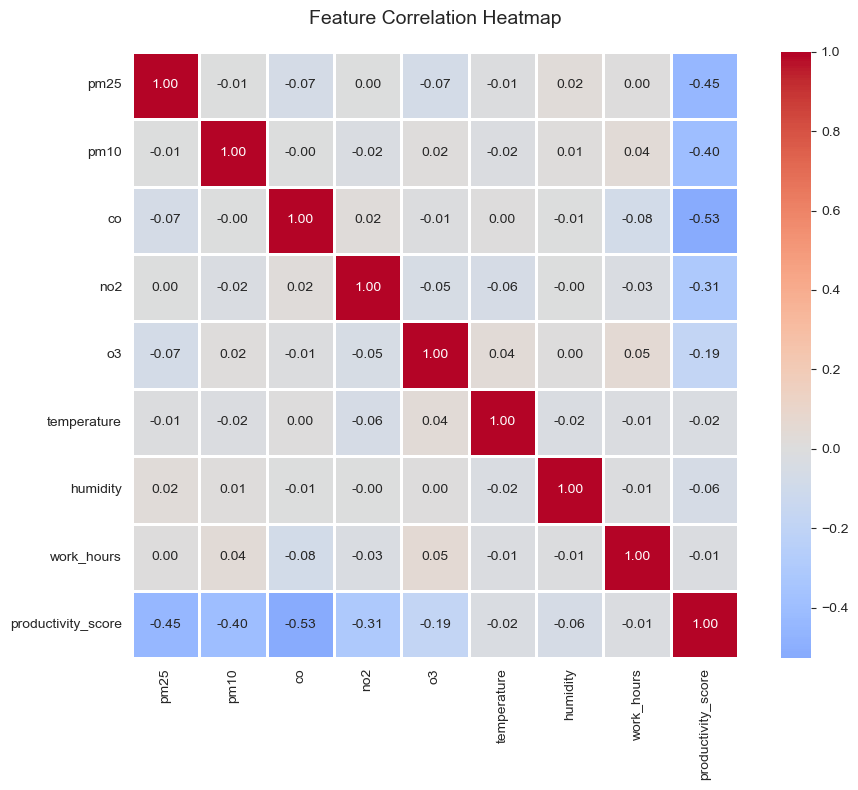

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), 
            annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1)
plt.title('Feature Correlation Heatmap', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

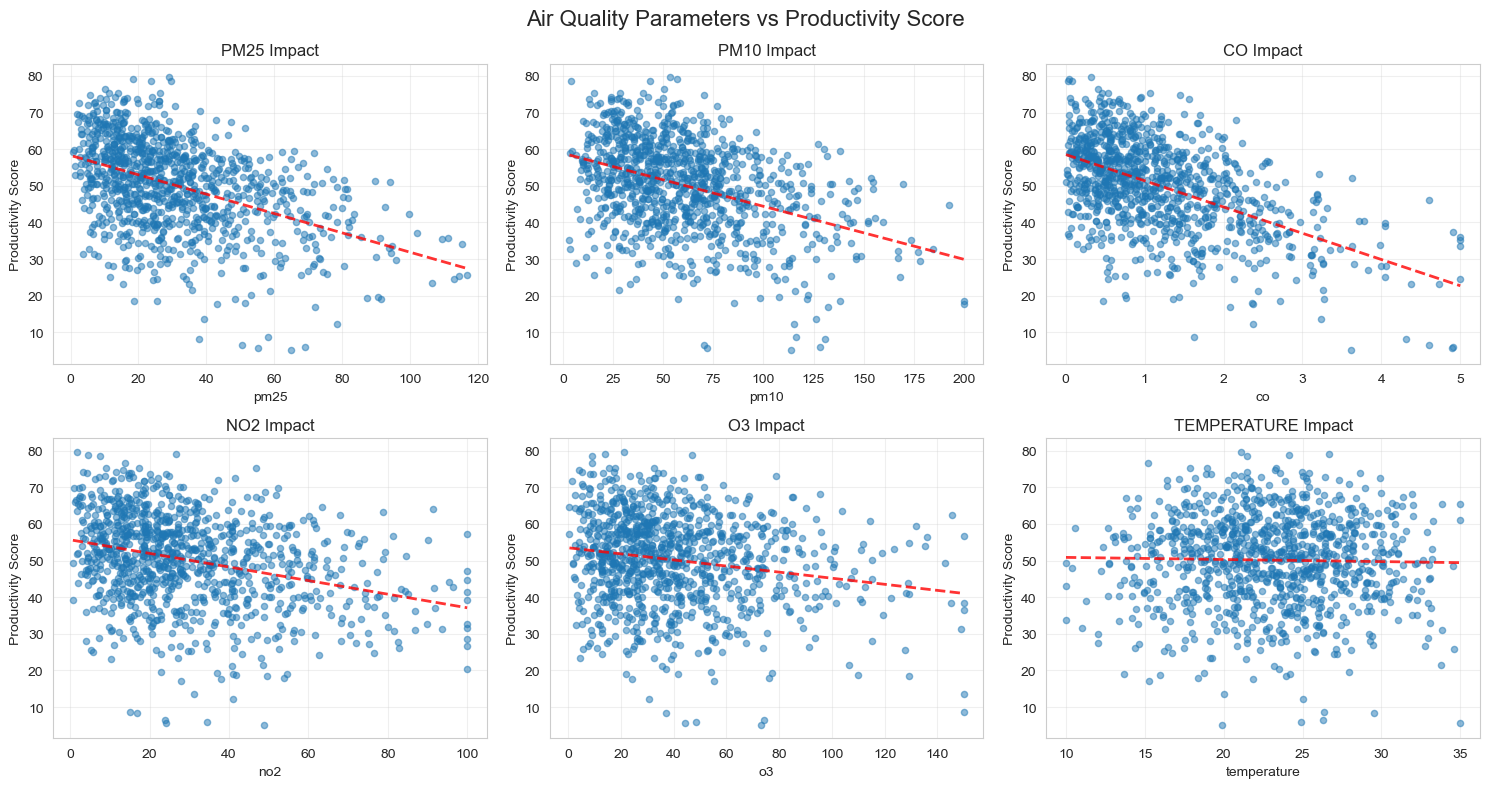

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Air Quality Parameters vs Productivity Score', fontsize=16)

pollutants = ['pm25', 'pm10', 'co', 'no2', 'o3', 'temperature']
for idx, pollutant in enumerate(pollutants):
    ax = axes[idx // 3, idx % 3]
    ax.scatter(df[pollutant], df['productivity_score'], alpha=0.5, s=20)
    ax.set_xlabel(pollutant)
    ax.set_ylabel('Productivity Score')
    ax.set_title(f'{pollutant.upper()} Impact')
    
    
    z = np.polyfit(df[pollutant], df['productivity_score'], 1)
    p = np.poly1d(z)
    ax.plot(df[pollutant].sort_values(), p(df[pollutant].sort_values()), 
            "r--", alpha=0.8, linewidth=2)
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
df['aqi_composite'] = (
    0.35 * df['pm25'] + 
    0.25 * df['pm10'] + 
    0.15 * df['no2'] + 
    0.15 * df['o3'] + 
    0.10 * df['co'] * 20
)

df['temp_comfort'] = 100 - 5 * np.abs(df['temperature'] - 22)
df['temp_comfort'] = df['temp_comfort'].clip(0, 100)

df['humidity_comfort'] = 100 - 2 * np.abs(df['humidity'] - 50)
df['humidity_comfort'] = df['humidity_comfort'].clip(0, 100)

df_encoded = pd.get_dummies(df, columns=['day_of_week', 'season'], drop_first=True)

In [14]:
print("New features created:")
print("- aqi_composite: Weighted composite air quality index")
print("- temp_comfort: Temperature comfort score")
print("- humidity_comfort: Humidity comfort score")
print("- One-hot encoded: day_of_week, season")

New features created:
- aqi_composite: Weighted composite air quality index
- temp_comfort: Temperature comfort score
- humidity_comfort: Humidity comfort score
- One-hot encoded: day_of_week, season


In [15]:
X = df_encoded.drop('productivity_score', axis=1)
y = df_encoded['productivity_score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 800
Test set size: 200


In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
  
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    
    print(f"  RMSE: {rmse:.3f}")
    print(f"  MAE: {mae:.3f}")
    print(f"  R² Score: {r2:.3f}")



Training Linear Regression...
  RMSE: 4.791
  MAE: 3.838
  R² Score: 0.829

Training Random Forest...
  RMSE: 5.362
  MAE: 4.234
  R² Score: 0.785

Training Gradient Boosting...
  RMSE: 5.446
  MAE: 4.335
  R² Score: 0.779


In [17]:
comparison_df = pd.DataFrame({
    'Model': results.keys(),
    'RMSE': [results[m]['RMSE'] for m in results.keys()],
    'MAE': [results[m]['MAE'] for m in results.keys()],
    'R² Score': [results[m]['R2'] for m in results.keys()]
})
print(comparison_df.to_string(index=False))

best_model_name = max(results.keys(), key=lambda x: results[x]['R2'])
best_model = results[best_model_name]['model']
print(f"\n Best Model: {best_model_name}")

            Model     RMSE      MAE  R² Score
Linear Regression 4.791020 3.838214  0.828630
    Random Forest 5.362393 4.233672  0.785317
Gradient Boosting 5.445980 4.335351  0.778572

 Best Model: Linear Regression


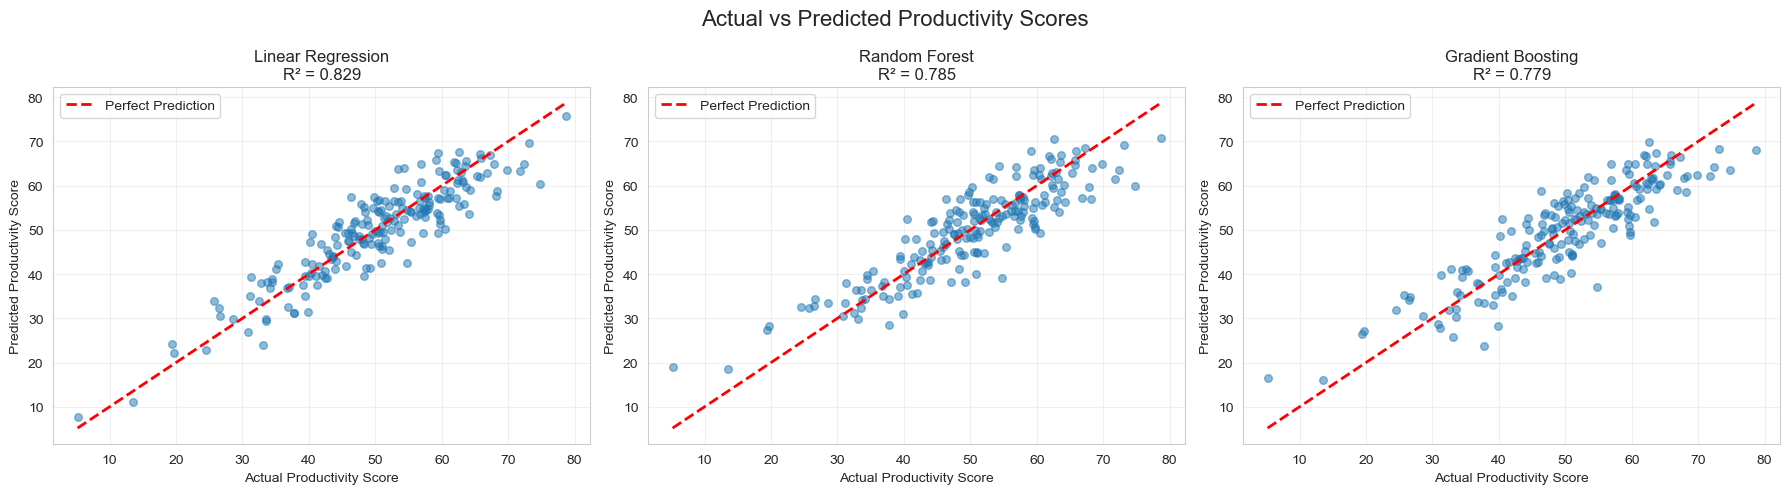

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Actual vs Predicted Productivity Scores', fontsize=16)

for idx, (name, result) in enumerate(results.items()):
    ax = axes[idx]
    ax.scatter(y_test, result['predictions'], alpha=0.5, s=30)
    ax.plot([y_test.min(), y_test.max()], 
            [y_test.min(), y_test.max()], 
            'r--', lw=2, label='Perfect Prediction')
    ax.set_xlabel('Actual Productivity Score')
    ax.set_ylabel('Predicted Productivity Score')
    ax.set_title(f"{name}\nR² = {result['R2']:.3f}")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

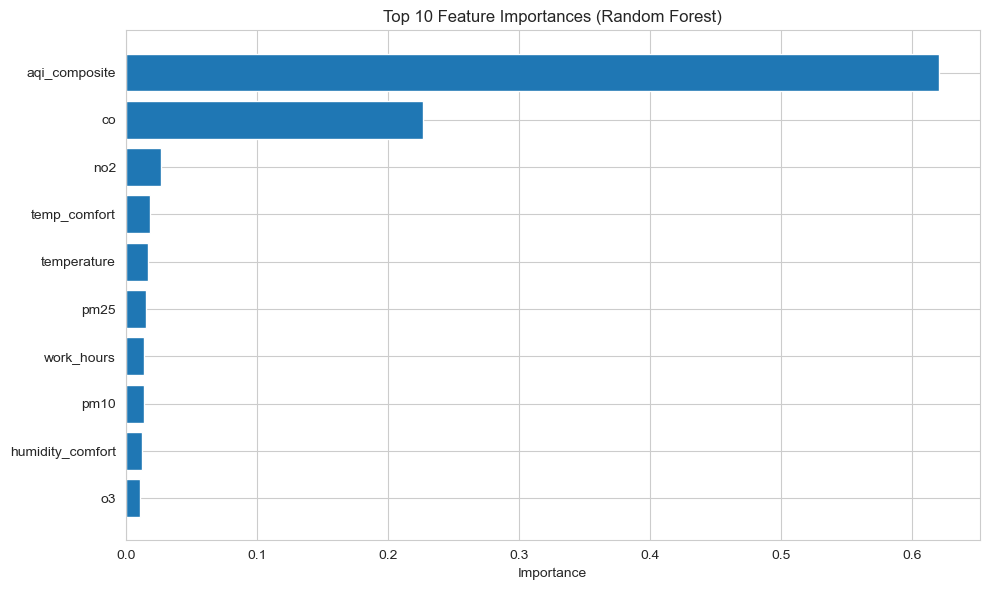


Top 10 Most Important Features:
         feature  importance
   aqi_composite    0.620573
              co    0.226497
             no2    0.026894
    temp_comfort    0.018194
     temperature    0.017365
            pm25    0.015777
      work_hours    0.014310
            pm10    0.014285
humidity_comfort    0.012645
              o3    0.011061


In [19]:
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.xlabel('Importance')
    plt.title('Top 10 Feature Importances (Random Forest)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.to_string(index=False))

In [20]:
with open('productivity_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(f" Best model saved: productivity_model.pkl")

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(" Scaler saved: scaler.pkl")

with open('feature_columns.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)
print(" Feature columns saved: feature_columns.pkl")

 Best model saved: productivity_model.pkl
 Scaler saved: scaler.pkl
 Feature columns saved: feature_columns.pkl
